Sampled 20000 points.
Saved sphere_samples.npz


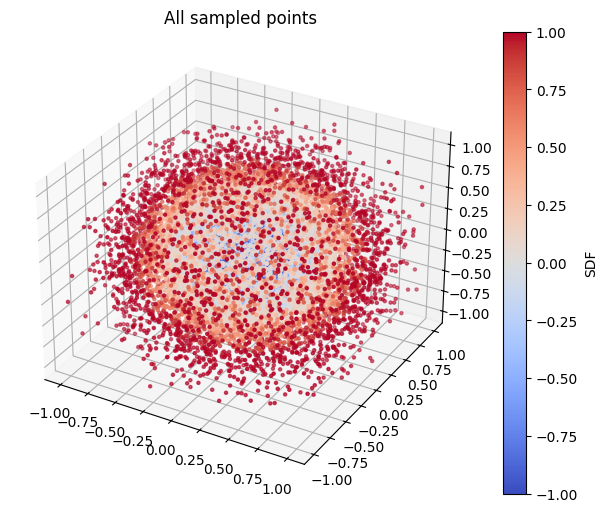

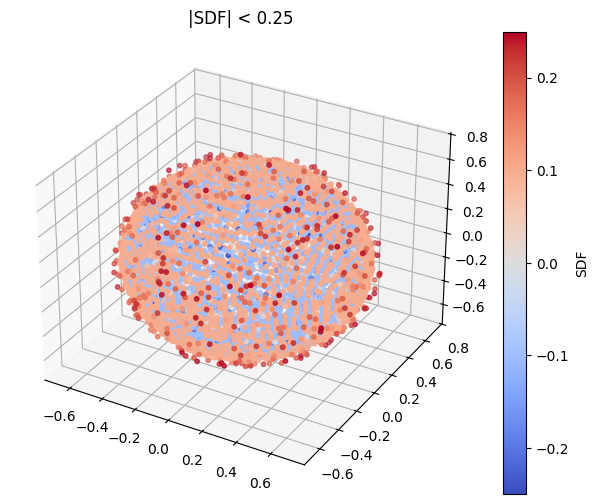

In [1]:
import numpy as np
import torch
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

# -----------------------------------------------------------------------------
# STEP 1. Generate a 3D sphere segmentation
# -----------------------------------------------------------------------------
def generate_sphere_segmentation(shape=(64, 64, 64), radius=20, center=None):
    if center is None:
        center = np.array(shape) / 2
    grid = np.indices(shape).transpose(1,2,3,0).astype(np.float32)  # (H,W,D,3)
    dists = np.linalg.norm(grid - center, axis=-1)
    seg = (dists <= radius).astype(np.float32)
    return seg

# -----------------------------------------------------------------------------
# STEP 2. Compute the SDF from the segmentation (normalized to [-1,1])
# -----------------------------------------------------------------------------
def compute_target_sdf(seg_mask, clip_threshold=10):
    seg_np = seg_mask.cpu().numpy()  # [1,1,H,W,D]
    bin_mask = seg_np > 0
    sdf_np = np.zeros_like(bin_mask, dtype=np.float32)
    for b in range(bin_mask.shape[0]):
        vol = bin_mask[b,0]
        dt_out = ndi.distance_transform_edt(~vol)
        dt_in  = ndi.distance_transform_edt(vol)
        sdf   = np.clip(dt_out - dt_in, -clip_threshold, clip_threshold) / clip_threshold
        sdf_np[b,0] = sdf
    return torch.from_numpy(sdf_np).to(seg_mask.device)

# -----------------------------------------------------------------------------
# STEP 3. Your UPDATED sample_sdf_balanced (surface + noisy)
# -----------------------------------------------------------------------------
def sample_sdf_balanced(sdf, num_points=10000, noise_std=0.3):
    """
    Half of the points are exactly on the discrete surface (smallest nonzero
    |SDF|), half are noisy perturbations of those points.
    """
    sdf_np = sdf.squeeze().cpu().numpy()  # [H,W,D]
    H,W,D = sdf_np.shape

    # 1) find the smallest nonzero |SDF| -> surface_val
    abs_vals = np.abs(sdf_np)
    nonzero  = abs_vals[abs_vals > 1e-6]
    surface_val = nonzero.min()

    # 2) get all voxels at that minimal distance
    surface_mask    = np.isclose(abs_vals, surface_val, atol=1e-6)
    surface_indices = np.argwhere(surface_mask)
    half = num_points // 2

    # 3a) sample half exactly on those voxels
    idx_surf = np.random.choice(len(surface_indices), size=half, 
                                replace=len(surface_indices)<half)
    pts_surf = surface_indices[idx_surf]

    # 3b) normalize to [-1,1]
    pts_surf_norm = pts_surf.astype(np.float32)
    pts_surf_norm[:,0] = (pts_surf_norm[:,0]/(H-1))*2 - 1
    pts_surf_norm[:,1] = (pts_surf_norm[:,1]/(W-1))*2 - 1
    pts_surf_norm[:,2] = (pts_surf_norm[:,2]/(D-1))*2 - 1

    # 4) noisy half
    pts_noisy_norm = pts_surf_norm + np.random.randn(*pts_surf_norm.shape)*noise_std
    pts_noisy_norm = np.clip(pts_noisy_norm, -1.0, 1.0)

    # 5) gather their ground-truth SDF
    sdf_surf = sdf_np[pts_surf[:,0], pts_surf[:,1], pts_surf[:,2]]
    coords_voxel = (pts_noisy_norm + 1)/2 * np.array([H-1, W-1, D-1])
    sdf_noisy = ndi.map_coordinates(
        sdf_np,
        [coords_voxel[:,0], coords_voxel[:,1], coords_voxel[:,2]],
        order=1, mode='nearest'
    )

    # stack and return
    coords_norm = np.vstack([pts_surf_norm, pts_noisy_norm])
    sdf_samples = np.concatenate([sdf_surf, sdf_noisy])
    return coords_norm, sdf_samples

# -----------------------------------------------------------------------------
# STEP 4. (Optional) scatter‐plot helpers
# -----------------------------------------------------------------------------
def plot_full_sdf_scatter(coords, sdf_vals):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(coords[:,0], coords[:,1], coords[:,2],
                    c=sdf_vals, cmap='coolwarm', s=5)
    plt.colorbar(sc, label='SDF')
    ax.set_title("All sampled points")
    plt.show()

def plot_surface_scatter(coords, sdf_vals, tol=0.3):
    mask = np.abs(sdf_vals) < tol
    if not mask.any():
        print("No near‐surface points.")
        return
    pts = coords[mask]
    vals = sdf_vals[mask]
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(pts[:,0], pts[:,1], pts[:,2],
                    c=vals, cmap='coolwarm', s=10)
    plt.colorbar(sc, label='SDF')
    ax.set_title(f"|SDF| < {tol}")
    plt.show()

# -----------------------------------------------------------------------------
# STEP 5. Main workflow
# -----------------------------------------------------------------------------
def main_workflow():
    # 1) make sphere seg
    shape = (64,64,64)
    radius = 20
    seg = generate_sphere_segmentation(shape, radius)
    seg_t = torch.from_numpy(seg).unsqueeze(0).unsqueeze(0)  # [1,1,H,W,D]

    # 2) compute SDF
    sdf_t = compute_target_sdf(seg_t, clip_threshold=10)

    # 3) sample surface + noisy
    coords, sdf_vals = sample_sdf_balanced(sdf_t, num_points=20000, noise_std=0.3)
    print("Sampled", coords.shape[0], "points.")

    # 4) save if you like
    np.savez_compressed("sphere_samples.npz", pos=coords, neg=sdf_vals)
    print("Saved sphere_samples.npz")

    # 5) visualize
    plot_full_sdf_scatter(coords, sdf_vals)
    plot_surface_scatter(coords, sdf_vals, tol=0.25)

if __name__=="__main__":
    main_workflow()
